In [1]:
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn-talk')
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

import copy

import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd

np.random.seed(1596)

from hmm import HMM
from vi import GammaNormal

In [2]:
def visualize_density(rv, resolution=300):
    tau = np.linspace(0.01,3,resolution)
    mu = np.linspace(-2,2,resolution)
    X, Y = np.meshgrid(mu, tau)
    Z = rv.pdf(Y, X)
    plt.contour(X, Y, Z, colors='green');
    
#     print(np.max(z))
#     levels = np.arange(0, np.max(z), 1e-200)
#     print(levels)
#     contour_plot = plt.contourf(mu, tau, z, levels, cmap=plt.cm.viridis)

In [7]:
dataX = np.random.normal(0,2,12)
alpha_0 = 1
beta_0 = 2
mu_0 = 0
lambda_0 = 2
gammaNormal = GammaNormal(dataX, alpha_0, beta_0, mu_0, lambda_0)

Gamma settings: 
 a:6.5, b:18.25875496247991
Norm settings: 
 mu:-0.6968447267642727, prec:14


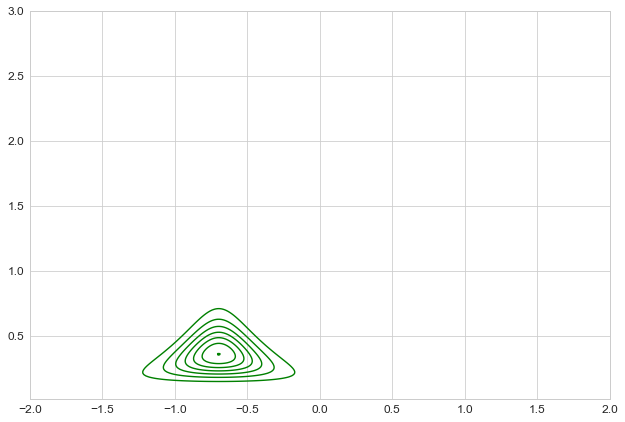

In [8]:
visualize_density(gammaNormal)

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10]*5+[1/2]
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)

# Testing Cond. Prob

In [ ]:
import copy
a = [[1,2,3],[1,2,3]]
c = copy.deepcopy(a)
b = a[:] # Does not work for double list... Need to make deep copy!
print(c)
b[1][0] = 0
c[0][0] = 10
print(a)
print(b)
print(c)

In [ ]:
def test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s):
    hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
    prob_table = hmm.calculate_conditional(k, s, observations_list)
#     df = pd.DataFrame(prob_table, columns=['state1', 'state2'], index=np.arange(1,7))
    fig, ax = plt.subplots()
    ind = np.arange(1,7)
    width = 0.20
    prob_table = prob_table * 100 # Convert to %
    print(prob_table[1,:])
    print(prob_table[0,:])
    ax.bar(ind+width, prob_table[0,:], label='$Z_{} = 1$'.format(k), color='r', width=0.4, alpha=0.9)
    ax.bar(ind-width, prob_table[1,:], label='$Z_{} = 2$'.format(k), color='b', width=0.4, alpha=0.9)
    ax.set_ylim([0, 100])
    ax.set_xticks(ind)
    ax.set_ylabel('Probability %')
    ax.set_xlabel('Dice Outcome: $X_{0}$'.format(k))
    ax.set_title('Probability: $p(Z_{}, X_{} | S, O_{})$'.format(k,k,'{1:t}'))
    ax.legend()
    print('Sum of probabilities: {}'.format(np.sum(prob_table)))

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10]*5+[1/2]
print(dice_dist2)
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5
k = 1
observations_list = [-1,6,5,6,-1,-1,-1] # 7 observations --> 7 tables
s = 24 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)

In [ ]:
k = 5
observations_list = [1,6,5,6,-1,2,1] # 7 observations --> 7 tables
s = 24 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)

In [ ]:
k = 5
observations_list = [1,2,5,4,-1,3,3] # 7 observations --> 7 tables
s = 24 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10] + [1/2] + [1/10]*4
# dice_dist2 = [1/2]+[1/10]*5
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5


k = 3
observations_list = [-1,2,-1,-1,2,2,-1] # 7 observations --> 7 tables
print(sum(observations_list) + 1)
s = 24 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)

# Change between 1s and 2s for observation. If we observe more 1s then state 1 should be more likely.
# if we observe more 2s, then state 2 should be more likley overall.

In [ ]:
# Should not be zero!!!!
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10] + [1/2] + [1/10]*4
# dice_dist2 = [1/2]+[1/10]*5
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5


k = 7
observations_list = [6,6,6,6,6,1,-1] # 7 observations --> 7 tables
print(sum(observations_list) + 1)
s = 33 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)

In [ ]:
# Should not be zero!!!!
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10] + [1/2] + [1/10]*4
print(dice_dist1)
print(dice_dist2)
# dice_dist2 = [1/2]+[1/10]*5
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5


k = 7
observations_list = [6,6,6,6,1,1,-1] # 7 observations --> 7 tables
print(sum(observations_list) + 1)
s = 28 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)

In [ ]:
# Should not be zero!!!!
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10] + [1/2] + [1/10]*4
# dice_dist2 = [1/2]+[1/10]*5
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5


k = 7
observations_list = [6,6,6,1,1,1,-1] # 7 observations --> 7 tables
print(sum(observations_list) + 1)
s = 23 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10] + [1/2] + [1/10]*4
# dice_dist2 = [1/2]+[1/10]*5
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5


k = 7
observations_list = [1,1,1,1,1,1,-1] # 7 observations --> 7 tables
print(sum(observations_list) + 1)
s = 8 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)


# 5x as likely to generate a 2 in state 2 than in state 1. This overpowers the fact that it is
# more likely to generate all previous observations in state 1. However, state 1 is still rather likely.

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10] + [1/2] + [1/10]*4
# dice_dist2 = [1/2]+[1/10]*5
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5


k = 7
observations_list = [1,1,1,1,1,1,-1] # 7 observations --> 7 tables
print(sum(observations_list) + 1)
s = 9 # Must be in (7, 42) for 7 tables.
test_plot_conditional(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe, k, observations_list, s)


# As soon as we switch sum to a number to which both dist1 and dist2 are indifferent towards,
# state 1 quickly becomes the more likely state since it is much more likely to transition to state 1 from state 1,
# and the previous observations should be more likely given state 1.

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/2]+[1/10]*5
dice_dist2 = [1/10]*5+[1/2]
transition_matrix = [[3/4, 1/4],[1/4, 3/4]]
prob_observe = 0.5

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)

k = 1
observations_list = [1,-1,-1,-1,1,1,-1] # 7 observations --> 7 tables
s = 24 # Must be in (7, 42) for 7 tables.
prob_table = hmm.calculate_conditional(k, s, observations_list)

In [ ]:
prob_table = np.transpose(prob_table)
df = pd.DataFrame(prob_table, columns=['state1', 'state2'], index=np.arange(1,7))

In [ ]:
for state in range(2):
    for x in range(6):
        print(x+1)
        print('Prob: {:.1f} %'.format(prob_table[state][x] * 100))

## Validating and Testing Prob (Sum)

In [ ]:
# Starts here.

# self, observed_sum, final_node, observations_list, z_k (k, z_k, x_k)
sum_result = hmm.find_prob_sum(observed_sum=24, final_node=7, observations_list=[-1,-1,-1,-1,-1,-1,-1], z_k=(1,1,5))
print(sum_result)

In [ ]:
hmm.evidence_matrix

In [ ]:
# TEST
hmm.reset()
for _ in range(10):
    hmm.run()

observed_outcomes = hmm.observed_outcomes.copy()
print(observed_outcomes)
observed_outcomes.reverse()
print(observed_outcomes)
starting_cond = hmm.forward_init(observed_outcomes.pop())

forward = hmm.forward(starting_cond, observed_outcomes)
print(forward)

hmm.semi_forward(hmm.observed_outcomes, 0)

# Validation of implementation

## All Dice Fair

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/6]*6
dice_dist2 = [1/6]*6
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
state_sequence = []
for _ in range(10000):
    state_sequence.append(hmm.state)
    hmm.run()

# plt.bar([0,1], [state_sequence.count(1), state_sequence.count(2)])

# plt.hist(hmm.actual_outcomes, 50, facecolor='green', alpha=0.75)
# plt.title('Distribution of outcomes from dice')
# plt.ylabel('Number of outcomes')
# plt.xlabel('Dice outcome')

outcome_seq = np.array(hmm.actual_outcomes)
state_seq = np.array(state_sequence)
state1_outcomes = outcome_seq[state_seq == 0]
state2_outcomes = outcome_seq[state_seq == 1]

f, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
axs[0].hist(outcome_seq, 50, facecolor='blue', alpha=0.75)
axs[0].set_title('Overall Dist. of outcomes')
axs[1].hist(state1_outcomes, 50, facecolor='red', alpha=0.75, label='State1')
axs[1].set_title('Dist. of outcomes from state 1')
axs[2].hist(state2_outcomes, 50, facecolor='green', alpha=0.75, label='State2')
axs[2].set_title('Dist. of outcomes from state 2')

## Table1 Dice fair, Table2 Dice biased

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [1/6]*6
dice_dist2 = [1/12]*4 + [2/6]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
state_sequence = []
for _ in range(10000):
    state_sequence.append(hmm.state)
    hmm.run()

# plt.hist(hmm.actual_outcomes, 50, facecolor='green', alpha=0.75)
# plt.title('Distribution of outcomes from dice')
# plt.ylabel('Number of outcomes')
# plt.xlabel('Dice outcome')

outcome_seq = np.array(hmm.actual_outcomes)
state_seq = np.array(state_sequence)
state1_outcomes = outcome_seq[state_seq == 0]
state2_outcomes = outcome_seq[state_seq == 1]

f, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
axs[0].hist(outcome_seq, 50, facecolor='blue', alpha=0.75)
axs[0].set_title('Overall Dist. of outcomes')
axs[1].hist(state1_outcomes, 50, facecolor='red', alpha=0.75, label='State1')
axs[1].set_title('Dist. of outcomes from state 1')
axs[2].hist(state2_outcomes, 50, facecolor='green', alpha=0.75, label='State2')
axs[2].set_title('Dist. of outcomes from state 2')

## Dice 1 biased, Dice 2 biased

In [ ]:
starting_prior = [1/2, 1/2]
dice_dist1 = [2/6]*2 + [1/12]*4
dice_dist2 = [1/12]*4 + [2/6]*2
transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
prob_observe = 1

hmm = HMM(starting_prior, dice_dist1, dice_dist2, transition_matrix, prob_observe)
state_sequence = []
for _ in range(10000):
    state_sequence.append(hmm.state)
    hmm.run()

# plt.hist(hmm.actual_outcomes, 50, facecolor='green', alpha=0.75)
# plt.title('Distribution of outcomes from dice')
# plt.ylabel('Number of outcomes')
# plt.xlabel('Dice outcome')

outcome_seq = np.array(hmm.actual_outcomes)
state_seq = np.array(state_sequence)
state1_outcomes = outcome_seq[state_seq == 0]
state2_outcomes = outcome_seq[state_seq == 1]

f, axs = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
axs[0].hist(outcome_seq, 50, facecolor='blue', alpha=0.75)
axs[0].set_title('Overall Dist. of outcomes')
axs[1].hist(state1_outcomes, 50, facecolor='red', alpha=0.75, label='State1')
axs[1].set_title('Dist. of outcomes from state 1')
axs[2].hist(state2_outcomes, 50, facecolor='green', alpha=0.75, label='State2')
axs[2].set_title('Dist. of outcomes from state 2')

# Computing p(X_k = l, Z_k = h | O, S)
Using dynamic programming

Eg. Compute (x_2 = 3, Z_2 = 1 | O, S)

In [ ]:
 ##### OLD VERSION #####
# TODO: REMEMBER TO UPDATE PREVIOUS HMM MODEL TO FIX STATES TO BE BETWEEN 0 and 1 isntead of 1 and 2....

transition_matrix = [[1/4, 3/4],[3/4, 1/4]]

# Calculates: prob(O_(1:K-1), Z_K = h)
def semi_forward(observations, current_state):
    """
        current_state: An integer representing the current state of hidden variable Z at time K. {0,1}
        observations: List of observations from time period 1:K-1. K being the current time.
    """
    total_sum = 0
    for prev_state in range(num_states):
        # P(O_(1:K-1), Z_K-1)
        forward = forward(observations, prev_state)
        # P(Z_K | Z_(K-1))
        transition_prob = transition_matrix[prev_state][current_state]
        total_sum += forward * transition_prob
    
    return total_sum

# Might run out of stack space?
def forward(observations, current_state):
    """  Calculates the forward f_k(h) := p(O_(1:K), Z_K = h)
    
    Variables:
        current_state: An integer representing the current state of hidden variable Z at time K. {0,1}
        observations: List of observations from time period 1:K. K being the current time.
    """
    
    current_observation = observations.pop() # Removes and returns last element of list
    evidence_prob = prob_observation(current_observation, current_state)
    
    # STOPPING CONDITION
    if len(observations) == 1:
        # p(O_1|Z_1) * p(Z_1)
        return evidence_prob * starting_prior[current_state]
    
    total_sum = 0
    for prev_state in range(num_states):
        # P(O_(1:K-1), Z_K-1)
        forward = forward(observations, prev_state) # Recursive call
        # P(Z_K | Z_(K-1))
        transition_prob = transition_matrix[prev_state][current_state]
        total_sum += forward * transition_prob
    
    return evidence_prob * total_sum

In [ ]:
# TODO: REMEMBER TO UPDATE PREVIOUS HMM MODEL TO FIX STATES TO BE BETWEEN 0 and 1 isntead of 1 and 2....

transition_matrix = [[1/4, 3/4],[3/4, 1/4]]
dice_dist1 = [1/12]*4 + [2/6]*2
dice_dist2 = [2/6]*2 + [1/12]*4
evidence_matrix = [dice_dist1, dice_dist2]


def semi_forward(observations, current_state):
    """ Calculates: prob(O_(1:K-1), Z_K = h)
    
    Variables:
        current_state: An integer representing the current state of hidden variable Z at time K. {0,1}
        observations: List of observations from time period 1:K-1. K being the current time.
    """
    observations.reverse() # Reverse so that we can pop from end of list corresponding to first time step
    starting_condition = forward_init(observations.pop()) # Get initial starting condition for forward
    forward = forward(starting_condition, observations) # Returns array of length = num_hidden_states
    
    total_sum = 0
    for prev_state in range(NUM_STATES): # Sum over all previous states
        transition_prob = transition_matrix[prev_state][current_state]
        total_sum += forward[prev_state] * transition_prob
    
    return total_sum

def forward_init(first_observation):
    forwards = np.empty(NUM_STATES) # Array to hold values for each state
    for state in range(NUM_STATES): # Loop through each state
        evidence_prob = prob_observation(first_observation, state)
        forwards[state] = evidence_prob * starting_prior[current_state]
    
    return forwards

def prob_observation(current_observation, current_state):
    """ Calculates P(O_k | Z_k)
    
    Variables:
        current_observation: Integer in range (-1,6) representing observation from hidden state
        current_state: Integer in range (0,1) representing the state of latent variable
    """
    # Int: -1 represents an "unobserved" observation
    if current_observation == -1:
        return 1 - PROB_OBSERVE
    else:
        return PROB_OBSERVE * evidence_matrix[current_state][current_observation]

def forward(prev_forwards, observations):
    """  Calculates the forward f_k(h) := p(O_(1:K), Z_K = h)
    
    Variables:
        current_state: An integer representing the current state of hidden variable Z at time K. {0,1}
        observations: List of observations from time period 1:K. K being the current time.
    """
    
    current_observation = observations.pop() # Removes and returns last element of list
    current_forward = np.empty(NUM_STATES) # To hold current forward values
    
    for current_state in range(NUM_STATES): # Loop through each current state
        evidence_prob = prob_observation(current_observation, current_state)
        total_sum = 0
        
        for prev_state in range(NUM_STATES): # Sum over all previous states
            transition_prob = transition_matrix[prev_state][current_state]
            total_sum += prev_forwards[prev_state] * transition_prob
        
        # Update current_forward value
        current_forward[current_state] = evidence_prob * total_sum
    
    # We have forwarded through all time steps until K-1
    if (len(observations) == 0):
        return current_forward
    
    future_forward = forward(current_forward, observations) # Recursive call moving forward
    
    # Return to top of calling stack
    return future_forward